# *This notebook contains:*
### A. EDA for movielens dataset
### B. Finding best and worst movies with deep learning aproach
### C. Implementation of ALS Matrix Factorization from scratch 

In [1]:
import os, time, random
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from matplotlib import style
style.use('fivethirtyeight')

from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Input, add, dot, Flatten, Embedding,Dropout, concatenate
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers

In [2]:
ratings = pd.read_csv('/home/badal/Desktop/movie_reco_data/ml-latest-small/ratings.csv')

In [3]:
movies = pd.read_csv('/home/badal/Desktop/movie_reco_data/ml-latest-small/movies.csv')

In [4]:
df = ratings.merge(movies, how = 'inner')
df['timestamp'] = df['timestamp'].apply(lambda x: time.strftime('%Y', time.localtime(x)))
df.rename(columns={'timestamp':'Year'}, inplace=True)

# A. EDA for movielens dataset

### For this section, I generated some questions that I want to answer.

# *Question 1:*
### What is the distubiton of user ratings ?

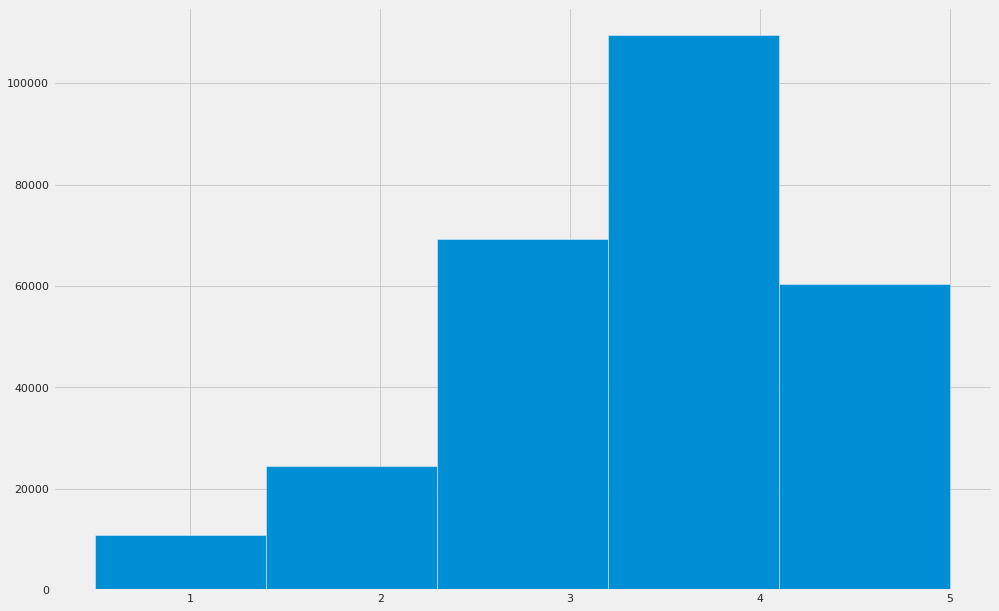

In [49]:
df.rating.hist(bins=5)

# *Question 2-1:*
### Is number of reviews correlated with higher ratings ?
    (Does most rated movies also get higher ratings ?)

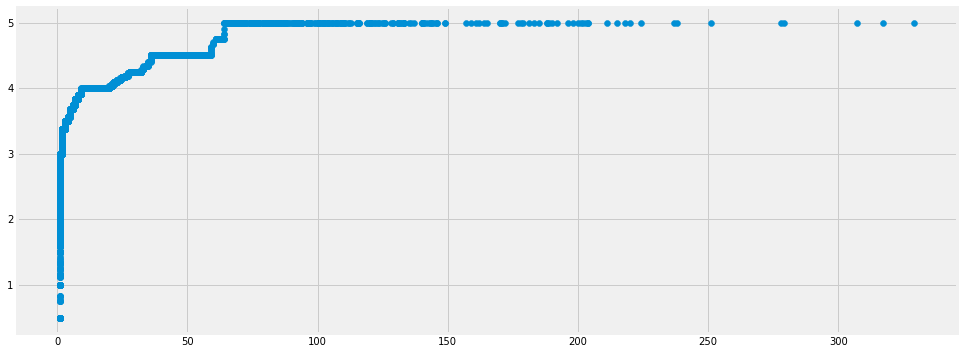

In [6]:

rating_counts = df.groupby('movieId')[['rating']].count().sort_values(by='rating', ascending=False)
avg_ratings = df.groupby('movieId')[['rating']].mean().sort_values(by='rating', ascending=False)
plt.figure(figsize=(15,6))
plt.scatter(rating_counts, avg_ratings)
plt.show()

Above plot shows, movies that got reviews more than 50 ended up getting ratings higher than 4

# *Question 2-2:*
### Does movies that get ratings above the average also ends up with higher number of reviews ?

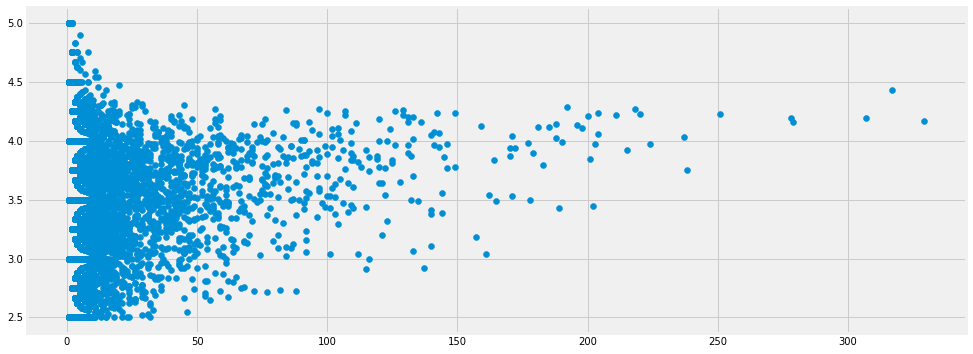

In [7]:
locs = avg_ratings[avg_ratings['rating'] >=2.5].index
plt.figure(figsize=(15,6))
plt.scatter(rating_counts.loc[locs], avg_ratings[avg_ratings['rating'] >=2.5]['rating'])
plt.show()

# Question 3:
### What are the most rated genres ? 

In [8]:
def explode(df, lst_cols, fill_value='', preserve_index=False):
    # make sure `lst_cols` is list-alike
    if (lst_cols is not None
        and len(lst_cols) > 0
        and not isinstance(lst_cols, (list, tuple, np.ndarray, pd.Series))):
        lst_cols = [lst_cols]
    # all columns except `lst_cols`
    idx_cols = df.columns.difference(lst_cols)
    # calculate lengths of lists
    lens = df[lst_cols[0]].str.len()
    # preserve original index values    
    idx = np.repeat(df.index.values, lens)
    # create "exploded" DF
    res = (pd.DataFrame({
                col:np.repeat(df[col].values, lens)
                for col in idx_cols},
                index=idx)
             .assign(**{col:np.concatenate(df.loc[lens>0, col].values)
                            for col in lst_cols}))
    # append those rows that have empty lists
    if (lens == 0).any():
        # at least one list in cells is empty
        res = (res.append(df.loc[lens==0, idx_cols], sort=False)
                  .fillna(fill_value))
    # revert the original index order
    res = res.sort_index()
    # reset index if requested
    if not preserve_index:        
        res = res.reset_index(drop=True)
    return res

In [9]:
df.genres = df.genres.str.split('|')
df = explode(df, ['genres'])

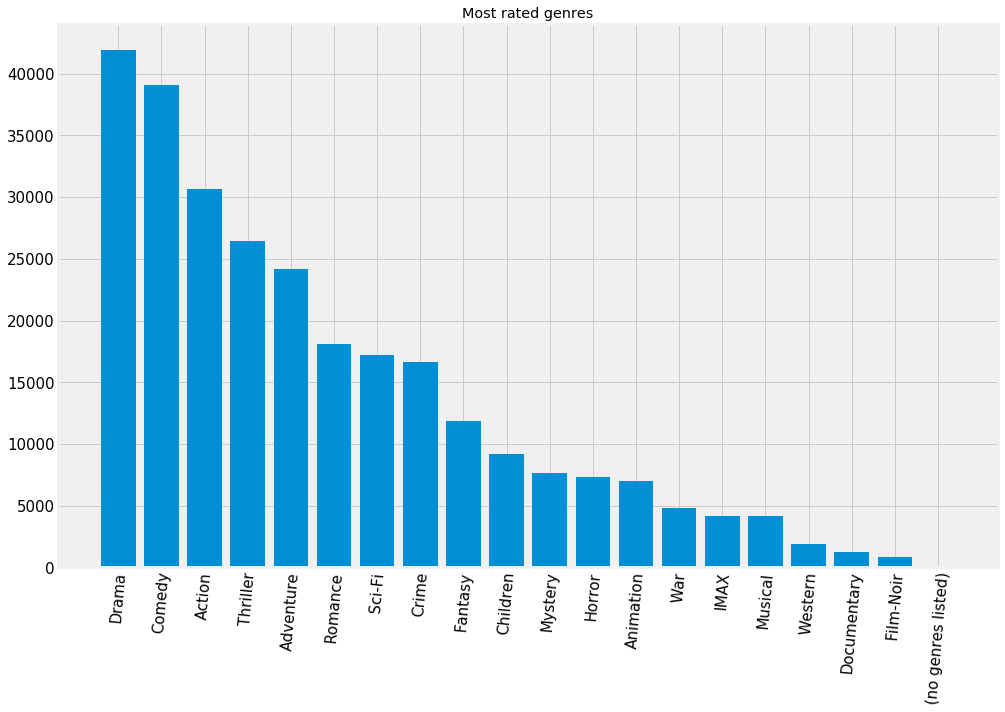

In [10]:
most_rated_genres =  df.groupby('genres')[['rating']].count().sort_values('rating', ascending=False)
figure = plt.figure(figsize=(15,10))
plt.bar(most_rated_genres.index, most_rated_genres.rating)
plt.xticks(rotation=85, fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('Most rated genres')
plt.show()

In [11]:
words = dict()
for i in df.genres.value_counts().iteritems():
    words[i[0]] = i[1]

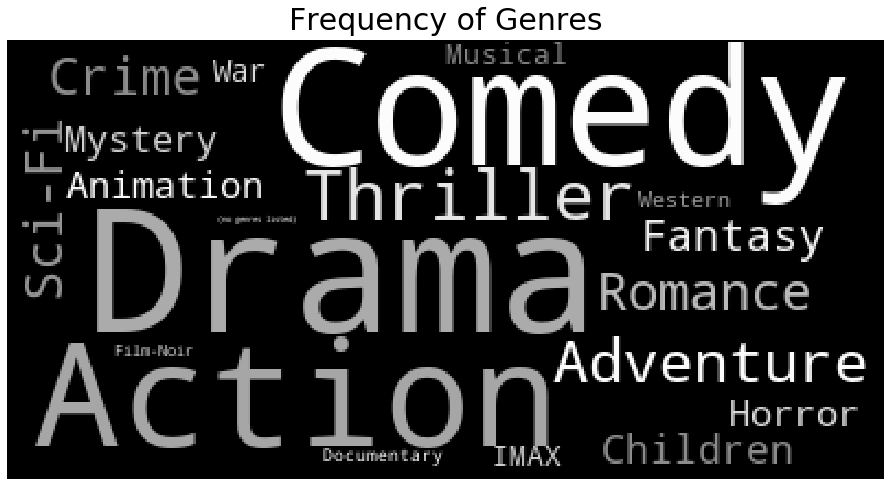

In [12]:
def grey_color(word, font_size, position, orientation, random_state=None, **kwargs):
    return 'hsl(0, 0%%, %d%%)' % random.randint(50, 100)

def generateWordCloud(words):
    limit = 1000
    infosize = 12
    title = 'Frequency of Genres'
    fontcolor='black'
    bgcolor = '#000000'

    wordcloud = WordCloud(
        max_words=500,
        background_color=bgcolor,
    ).generate_from_frequencies(words)
    fig = plt.figure()
    fig.set_figwidth(14)
    fig.set_figheight(18)
    plt.imshow(wordcloud.recolor(color_func=grey_color, random_state=3))
    plt.title(title, color=fontcolor, size=30, y=1.01)
    plt.axis('off')
    plt.show()

generateWordCloud(words)

# Question 4:
### What are the most rated movies ?

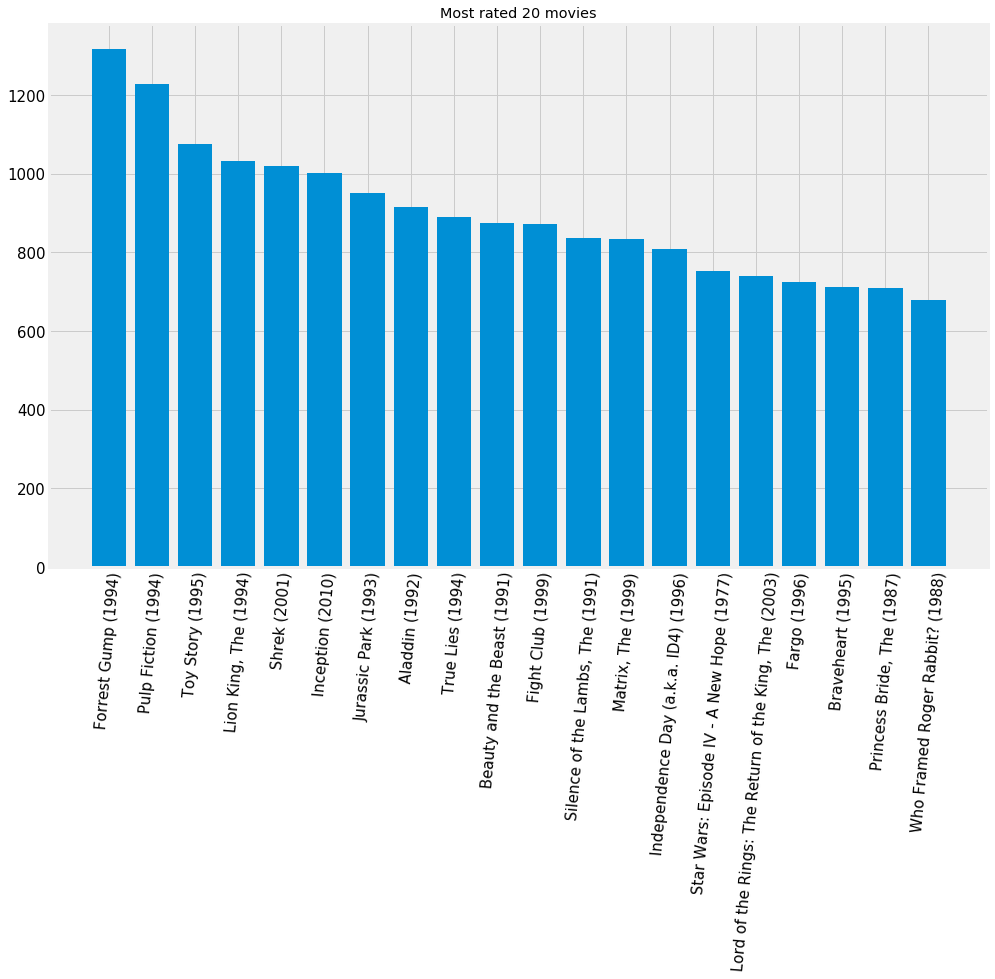

In [13]:
most_rated_movies = df.groupby('title')[['rating']].count().sort_values('rating', ascending=False)[:20]
figure = plt.figure(figsize=(15,10))
plt.bar(most_rated_movies.index, most_rated_movies.rating)
plt.xticks(rotation=85, fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('Most rated 20 movies')
plt.show()

# Question 5:
### What is the rating trend in movie genres ? 

In [14]:
rating_by_gen_year = df.groupby(['genres', 'Year'])[['rating']].mean()

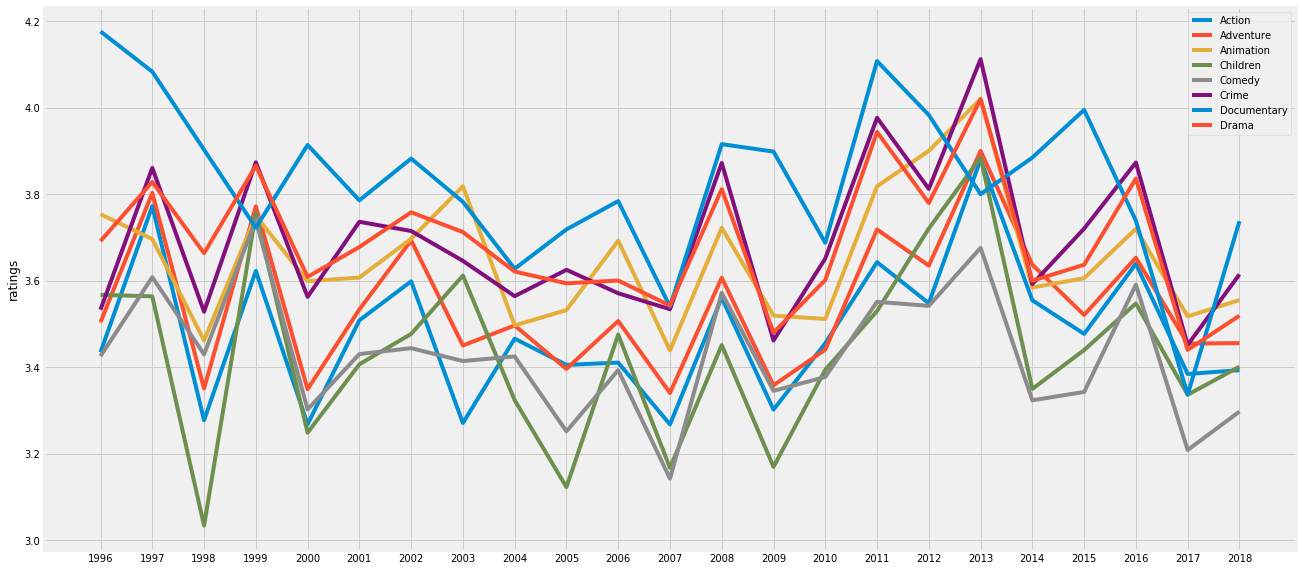

In [15]:
plt.figure(figsize=(20,10))
for i in rating_by_gen_year.index.levels[0].to_list()[:9]:
    if i == '(no genres listed)':
        continue
    plt.plot(rating_by_gen_year.loc[i].index, rating_by_gen_year.loc[i], label=i, linewidth=4)
plt.ylabel('ratings')
plt.legend(loc='best')
plt.show()

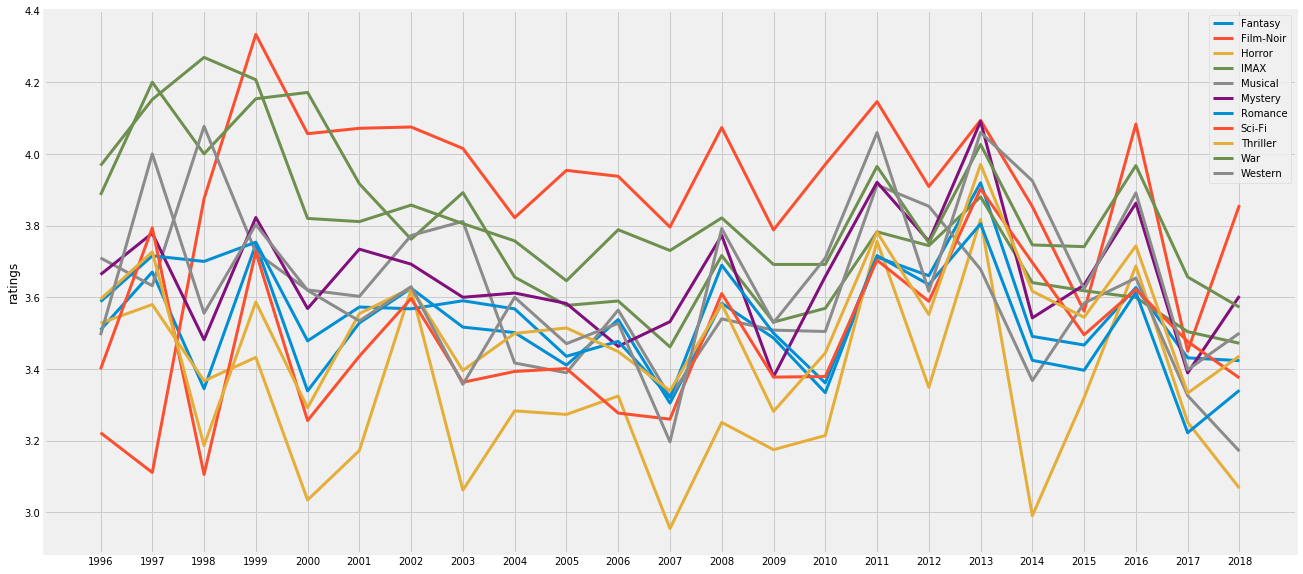

In [16]:
plt.figure(figsize=(20,10))
for i in rating_by_gen_year.index.levels[0].to_list()[9:]:
    if i == '(no genres listed)':
        continue
    plt.plot(rating_by_gen_year.loc[i].index, rating_by_gen_year.loc[i], label=i, linewidth = 3)
plt.ylabel('ratings')
plt.legend(loc='best')
plt.show()

# Question 6:
### What is the distribution of ratings by genres ? 

In [17]:
rts_by_mId_gen = df.groupby(['movieId', 'genres'], as_index=False)[['rating']].mean()

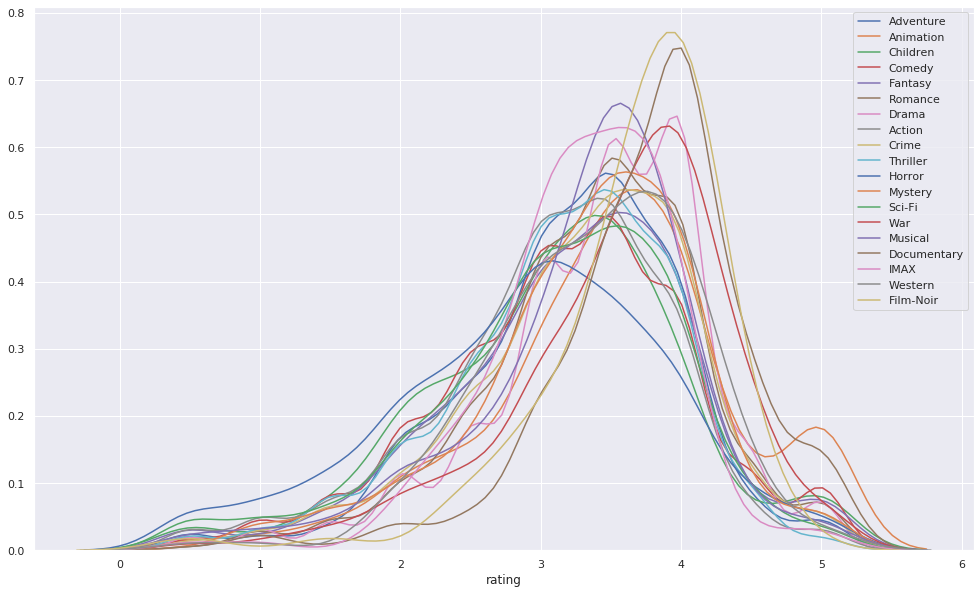

In [18]:
sns.set(rc={'figure.figsize':(15,10)})
for v in rts_by_mId_gen.genres.unique():
    if v == '(no genres listed)':
        continue
    fig = sns.distplot(rts_by_mId_gen[rts_by_mId_gen['genres'] == v]['rating'],hist=False, label=v)
plt.show()

# Question 7:
### Movies with witch release date got more reviews ?

In [19]:
df['release_date'] = df.title.str[-5:-1]

In [20]:
rts_by_users = df.groupby('userId')[['rating']].mean().sort_values('rating', ascending=False)

In [21]:
df_to_plot = df.set_index('userId').loc[rts_by_users[rts_by_users['rating'] >= 3].index]

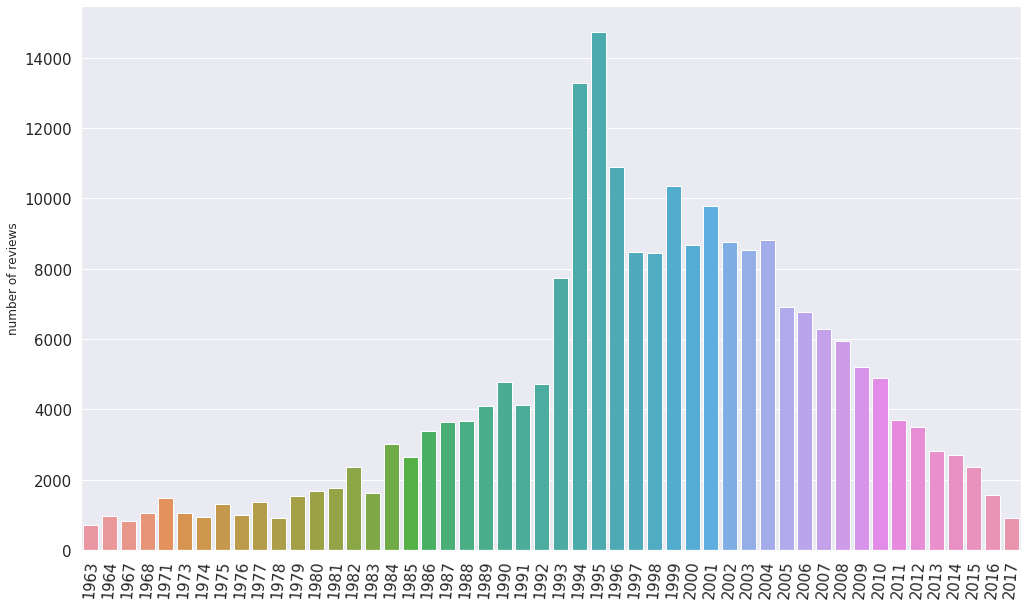

In [22]:
sns.barplot(x = df_to_plot.release_date.value_counts()[:50].index, 
            y = df_to_plot.release_date.value_counts()[:50])
plt.ylabel('number of reviews')
plt.xticks(rotation=85, fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()

# Question 8:
### What is the number of reviews by genre ?

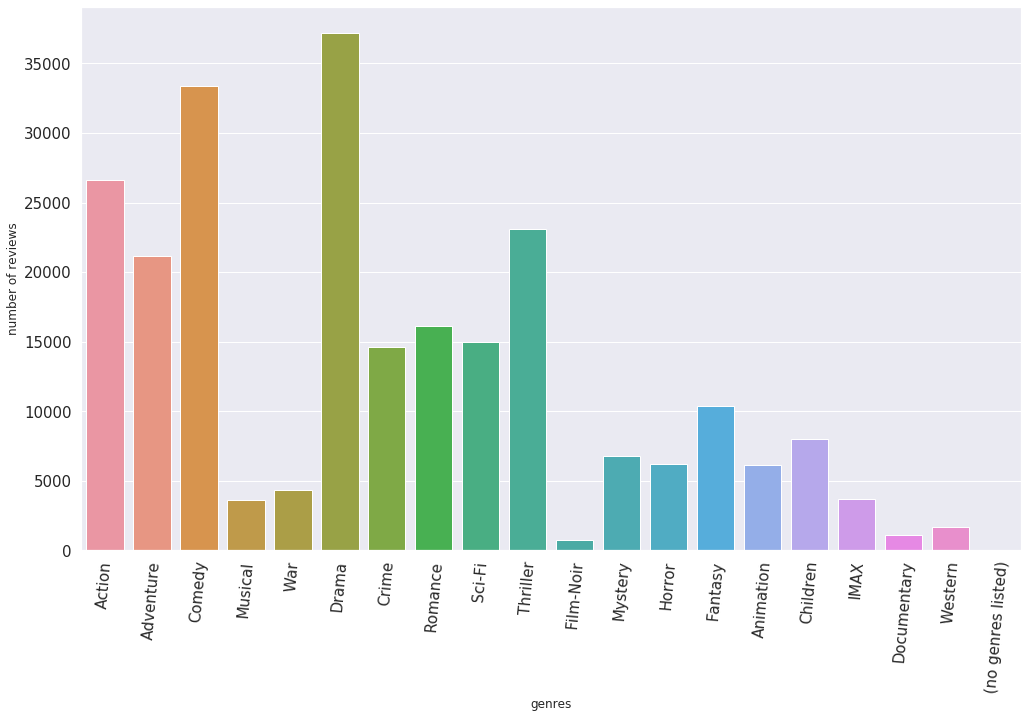

In [23]:
sns.countplot(x = df_to_plot.genres)
plt.xticks(rotation=85, fontsize = 15)
plt.yticks(fontsize = 15)
plt.ylabel('number of reviews')
plt.show()

# B. Finding Best and Worst Movies

In [24]:
ratings.drop('timestamp', 1, inplace=True)

In [25]:
# Those are the movies in movies.csv that doesn't exist in ratings.csv
movies_not_in_ratings = [i for i in movies.movieId if i not in ratings.movieId.unique()]
indcs = movies.set_index('movieId').loc[movies_not_in_ratings].index
movies = movies.set_index('movieId').drop(index=indcs).reset_index()

In [26]:
def proc_data_for_model(ratings_data, movie_col, user_col):
    """
    Process ratings and movies datasets.
    Changes userIds in ratings data with corresponding indices.
    Changes movieIds in ratings and movies data with corresponding indices.
    Returns: Number of unique users and number of unique movies in ratings dataset.
    """
    unique_users = ratings[user_col].unique()
    user_to_indx = {v:i for i,v in enumerate(unique_users)}
    ratings[user_col] = ratings[user_col].apply(lambda val: user_to_indx[val])
    n_users = len(unique_users)
        
    unique_movies = ratings[movie_col].unique()
    movie_to_indx = {o:i for i,o in enumerate(unique_movies)}
    movies[movie_col] = movies[movie_col].apply(lambda val: movie_to_indx[val])
    ratings[movie_col] = ratings[movie_col].apply(lambda val: movie_to_indx[val])
    n_movies=len(unique_movies)
    return n_users, n_movies

In [27]:
n_users, n_movies = proc_data_for_model(ratings, 'movieId', 'userId')

In [28]:
n_factors = 50  # size of embedding matrix.

In [29]:
def get_input(n_inputs, shape=(1,)):
    inputs = [Input(shape=shape) for arg in range(n_inputs)]
    return inputs
    
def get_emb(input_, input_dim, output_dim, inp_length, reg_func, name):
    emb = Embedding(input_dim, output_dim, input_length=inp_length, embeddings_regularizer=reg_func, name=name)(input_)
    return emb

def get_bias_emb(input_, input_dim):
    bias_emb = Embedding(input_dim=input_dim, output_dim=1, input_length=1)(input_)
    bias_emb = Flatten()(bias_emb)
    return bias_emb

In [30]:
u_inp, m_inp = get_input(2)
u_emb = get_emb(u_inp, n_users, n_factors, 1, l2(1e-4), 'user_embedding')
m_emb = get_emb(m_inp, n_movies, n_factors, 1, l2(1e-4), 'movie_embedding')
u_b, m_b = get_bias_emb(u_inp, n_users), get_bias_emb(m_inp, n_movies)

In [31]:
opt = optimizers.SGD(1e-1, decay=2e-4, momentum=0.9)

In [32]:
x = dot([u_emb, m_emb], axes=2)
x = Flatten()(x)
x = add([x, u_b])
x = add([x, m_b])
model = models.Model([u_inp, m_inp], x)
model.compile(opt, loss='mse')

In [33]:
train, val = train_test_split(ratings, test_size = 0.20)

In [34]:
model.fit([train.userId, train.movieId], train.rating, batch_size=512, epochs=15, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80668 samples, validate on 20168 samples
Epoch 1/15
80668/80668 [==============================] - 2s 20us/sample - loss: 6.4660 - val_loss: 3.2932
Epoch 2/15
80668/80668 [==============================] - 1s 16us/sample - loss: 2.4429 - val_loss: 2.0262
Epoch 3/15
80668/80668 [==============================] - 1s 16us/sample - loss: 1.7102 - val_loss: 1.6170
Epoch 4/15
80668/80668 [==============================] - 1s 18us/sample - loss: 1.4182 - val_loss: 1.4142
Epoch 5/15
80668/80668 [==============================] - 1s 14us/sample - loss: 1.2579 - val_loss: 1.2915
Epoch 6/15
80668/80668 [==============================] - 1s 14us/sample - loss: 1.1545 - val_loss: 1.2063
Epoch 7/15
80668/80668 [==============================] - 1s 14us/sample - loss: 1.0815 - val_loss: 1.1452
Epoch 8/15
80668/80668 [==============================] - 1s 15us/sample - loss: 1.0263 - val_loss: 1.0977
Epoch 9/15
80668/80668 [==============================] - 1s 14us/sample - loss: 0.9835 - val_

In [35]:
model.optimizer.lr = 1e-4
model.optimizer.decay = 2e-6

In [36]:
model.fit([train.userId, train.movieId], train.rating, batch_size=512, epochs=10, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80668 samples, validate on 20168 samples
Epoch 1/10
80668/80668 [==============================] - 1s 14us/sample - loss: 0.8301 - val_loss: 0.9295
Epoch 2/10
80668/80668 [==============================] - 1s 14us/sample - loss: 0.8274 - val_loss: 0.9285
Epoch 3/10
80668/80668 [==============================] - 1s 13us/sample - loss: 0.8264 - val_loss: 0.9281
Epoch 4/10
80668/80668 [==============================] - 1s 13us/sample - loss: 0.8258 - val_loss: 0.9279
Epoch 5/10
80668/80668 [==============================] - 1s 13us/sample - loss: 0.8254 - val_loss: 0.9277
Epoch 6/10
80668/80668 [==============================] - 1s 13us/sample - loss: 0.8250 - val_loss: 0.9276
Epoch 7/10
80668/80668 [==============================] - 1s 13us/sample - loss: 0.8248 - val_loss: 0.9275
Epoch 8/10
80668/80668 [==============================] - 1s 13us/sample - loss: 0.8246 - val_loss: 0.9274
Epoch 9/10
80668/80668 [==============================] - 1s 14us/sample - loss: 0.8244 - val_

In [37]:
movie_names = movies.set_index('movieId')['title'].to_dict()
g=ratings.groupby('movieId')['rating'].count()

#TopMovies are movies that got more reviews than others. 
topMovies=g.sort_values(ascending=False).index.values[:3000]

In [38]:
uniq = ratings.movieId.unique()
name2idx = {o:i for i,o in enumerate(uniq)}
topMovieIdx = np.array([name2idx[o] for o in topMovies])

In [39]:
get_movie_bias = models.Model(m_inp, m_b)
movie_bias = get_movie_bias.predict(topMovieIdx)

In [40]:
movie_ratings = [(b[0], movie_names[i]) for i,b in zip(topMovies,movie_bias)]

### Worst movies

In [41]:
sorted(movie_ratings, key=lambda o: o[0])[:15]

[(-0.56792986, 'Jason X (2002)'),
 (-0.46326447, 'Catwoman (2004)'),
 (-0.45739982, 'Anaconda (1997)'),
 (-0.4456217, 'Wild Wild West (1999)'),
 (-0.4395333, 'Godzilla (1998)'),
 (-0.43318188, 'Problem Child (1990)'),
 (-0.43268412, 'Battlefield Earth (2000)'),
 (-0.4289291, 'Spice World (1997)'),
 (-0.41541767, 'Rocky V (1990)'),
 (-0.40057603, 'Batman & Robin (1997)'),
 (-0.37321275, 'Stuart Saves His Family (1995)'),
 (-0.36449382, 'Speed 2: Cruise Control (1997)'),
 (-0.35593426, 'Sister Act 2: Back in the Habit (1993)'),
 (-0.35266706, 'Problem Child 2 (1991)'),
 (-0.3495998, 'Superman IV: The Quest for Peace (1987)')]

### Best movies
#### I will use these movies in my online recommender app.

In [42]:
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:48]

[(1.9040622, 'Shawshank Redemption, The (1994)'),
 (1.6966902, "Schindler's List (1993)"),
 (1.6885208, 'Fight Club (1999)'),
 (1.6675477, 'Usual Suspects, The (1995)'),
 (1.6316774, 'Braveheart (1995)'),
 (1.6184233, 'Dark Knight, The (2008)'),
 (1.610502, 'Silence of the Lambs, The (1991)'),
 (1.6090298, 'Pulp Fiction (1994)'),
 (1.6065029, 'Star Wars: Episode IV - A New Hope (1977)'),
 (1.604449, 'Forrest Gump (1994)'),
 (1.6007445,
  'Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)'),
 (1.5898674, 'Departed, The (2006)'),
 (1.5778276, 'Matrix, The (1999)'),
 (1.5777076, 'American History X (1998)'),
 (1.5638227,
  'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964)'),
 (1.5425856, 'Godfather, The (1972)'),
 (1.5342065, 'Lord of the Rings: The Return of the King, The (2003)'),
 (1.5259457, "One Flew Over the Cuckoo's Nest (1975)"),
 (1.519631, 'Eternal Sunshine of the Spotless Mind (2004)'),
 (1.5184793, 'Goodfellas (1990)'),
 

# C. Alternating Least Square (ALS) Matrix Factorization
### *Implementation of vanilla ALS with numpy*

In [43]:
Q = np.array([

     [5,3,0,1],

     [4,0,0,1],

     [1,1,0,5],

     [1,0,0,4],

     [0,1,5,4]

    ])

In [44]:
def get_error(Q, X, Y, W):
    return np.sum((W * (Q - np.dot(X, Y)))**2)

def vanilla_ALS(Q, n_iterations, n_factors, lambda_):
    m, n = Q.shape
    X = 5 * np.random.rand(m, n_factors) 
    Y = 5 * np.random.rand(n_factors, n)
    W = Q>0.5
    W[W == True] = 1
    W[W == False] = 0
    W = W.astype(np.float64, copy=False)
    
    trckr_x = 0
    trckr_y = 0
    weighted_errors = []
    for ii in range(n_iterations):
        for u, Wu in enumerate(W):
#             X[u] = np.linalg.solve(np.dot(Y, np.dot(np.diag(Wu), Y.T)) + lambda_ * np.eye(n_factors),
#                                    np.dot(Y, np.dot(np.diag(Wu), Q[u].T))).T
            X[u] = np.dot(np.linalg.inv(np.dot(Y, np.dot(np.diag(Wu), Y.T)) + lambda_ * np.eye(n_factors)),
                   np.dot(Y, np.dot(np.diag(Wu), Q[u].T))).T
    
        for i, Wi in enumerate(W.T):
#             Y[:,i] = np.linalg.solve(np.dot(X.T, np.dot(np.diag(Wi), X)) + lambda_ * np.eye(n_factors),
#                                    np.dot(X.t, np.dot(np.diag(Wi), Q[:,i])))
        
            Y[:,i] = np.dot(np.linalg.inv(np.dot(X.T, np.dot(np.diag(Wi), X)) + lambda_ * np.eye(n_factors)),
                                     np.dot(X.T, np.dot(np.diag(Wi), Q[:, i])))
        weighted_errors.append(get_error(Q, X, Y, W))
        #print('{}th iteration is completed'.format(ii))
    weighted_Q_hat = np.dot(X,Y)
    return weighted_Q_hat, weighted_errors

In [45]:
q_hat, errs =vanilla_ALS(Q, n_iterations=70, n_factors=3, lambda_=0.2)

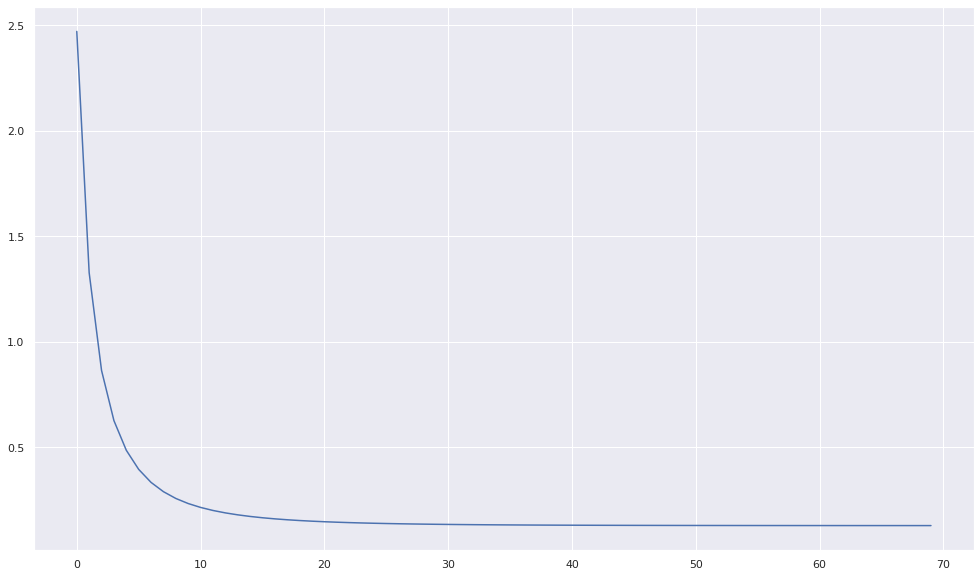

In [46]:
plt.plot(errs)
plt.show()

In [47]:
Q, q_hat

(array([[5, 3, 0, 1],
        [4, 0, 0, 1],
        [1, 1, 0, 5],
        [1, 0, 0, 4],
        [0, 1, 5, 4]]),
 array([[4.89022911, 2.87438891, 1.0162807 , 1.01247584],
        [3.8583496 , 2.28409218, 0.92635897, 0.99497346],
        [1.01015749, 0.97716292, 3.15950887, 4.84446615],
        [0.99069929, 0.88590597, 2.54134499, 3.87543962],
        [1.17159665, 0.99996177, 4.79999875, 3.99998678]]))

# The End